In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
#import warnings
#warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, LSTM, Embedding
from tensorflow.keras.utils import to_categorical

In [2]:
data = pd.read_csv('datasets/sequence_data.csv')
target = '1200'
df = data[['short_name', 'sequence', target]]

In [3]:
def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]
df['words'] = df.apply(lambda x: getKmers(x['sequence']), axis=1)
texts = list(df['words'])
for item in range(len(texts)):
    texts[item] = ' '.join(texts[item])

<ipython-input-3-2c0263da2d6b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['words'] = df.apply(lambda x: getKmers(x['sequence']), axis=1)


In [4]:
cv = CountVectorizer()
X = cv.fit_transform(texts).toarray()
y = df[target]
num_classes = 3
yc = pd.qcut(y, num_classes, labels=False)
yh = to_categorical(yc)

### Classification

#### Multi-layer Perceptrons

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, yh, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(132, 64) (33, 64) (132, 3) (33, 3)


In [6]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 6,803
Trainable params: 6,803
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(X_train, y_train, batch_size=100, epochs=10)

Epoch 1/10
2/2 [==============================] - 1s 3ms/step - loss: 46.4834 - accuracy: 0.3333
Epoch 2/10
2/2 [==============================] - 0s 6ms/step - loss: 25.0684 - accuracy: 0.3333
Epoch 3/10
2/2 [==============================] - 0s 6ms/step - loss: 13.6104 - accuracy: 0.3333
Epoch 4/10
2/2 [==============================] - 0s 7ms/step - loss: 4.8213 - accuracy: 0.3182
Epoch 5/10
2/2 [==============================] - 0s 10ms/step - loss: 7.2509 - accuracy: 0.4015
Epoch 6/10
2/2 [==============================] - 0s 12ms/step - loss: 9.8801 - accuracy: 0.3485
Epoch 7/10
2/2 [==============================] - 0s 10ms/step - loss: 8.9795 - accuracy: 0.3712
Epoch 8/10
2/2 [==============================] - 0s 8ms/step - loss: 8.7764 - accuracy: 0.3106
Epoch 9/10
2/2 [==============================] - 0s 6ms/step - loss: 6.7552 - accuracy: 0.2955
Epoch 10/10
2/2 [==============================] - 0s 5ms/step - loss: 4.2839 - accuracy: 0.3485


In [8]:
_, acc = model.evaluate(X_test, y_test, verbose=1)
print("accuracy = " + str(acc))

2/2 [==============================] - 0s 2ms/step - loss: 2.4611 - accuracy: 0.2424
accuracy = 0.24242424964904785


#### CNN

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, yc, test_size=0.2, random_state=42)

#reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.values.reshape((y_train.shape[0], 1))
y_test = y_test.values.reshape((y_test.shape[0], 1))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(132, 64, 1) (33, 64, 1) (132, 1) (33, 1)


In [10]:
verbose, epochs, batch_size = 0, 5, 100
n_timesteps, n_features, n_outputs = X_train.shape[1], 1, y_train.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 62, 64)            256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 64)            12352     
_________________________________________________________________
dropout (Dropout)            (None, 60, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               192100    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [11]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
accuracy

Epoch 1/5
2/2 [==============================] - 1s 20ms/step - loss: 0.0000e+00 - accuracy: 0.3258
Epoch 2/5
2/2 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 0.3182
Epoch 3/5
2/2 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 0.3182
Epoch 4/5
2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.3182
Epoch 5/5
2/2 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 0.3106


0.39393940567970276

#### RNN

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, yc, test_size=0.2, random_state=42)

#reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.values.reshape((y_train.shape[0], 1))
y_test = y_test.values.reshape((y_test.shape[0], 1))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(132, 64, 1) (33, 64, 1) (132, 1) (33, 1)


In [13]:
model = Sequential()
'''
top_words = 5000
max_review_length = 500
embedding_vecor_length = 32
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
'''
model.add(LSTM(64, input_shape=(n_timesteps, n_features)))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
#model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
#model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
accuracy

Epoch 1/5
2/2 [==============================] - 2s 42ms/step - loss: 0.0000e+00 - accuracy: 0.3333
Epoch 2/5
2/2 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - accuracy: 0.3333
Epoch 3/5
2/2 [==============================] - 0s 46ms/step - loss: 0.0000e+00 - accuracy: 0.3333
Epoch 4/5
2/2 [==============================] - 0s 40ms/step - loss: 0.0000e+00 - accuracy: 0.3106
Epoch 5/5
2/2 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - accuracy: 0.3182


0.39393940567970276

### Regression

#### CNN

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.values.reshape((y_train.shape[0], 1))
y_test = y_test.values.reshape((y_test.shape[0], 1))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(132, 64, 1) (33, 64, 1) (132, 1) (33, 1)


In [16]:
verbose, epochs, batch_size = 0, 5, 100
n_timesteps, n_features, n_outputs = X_train.shape[1], 1, y_train.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 62, 64)            256       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 60, 64)            12352     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 30, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               192100    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [17]:
model.fit(X_train, y_train, epochs=100, batch_size=5, verbose=1)
y_pred = model.predict(X_test)

Epoch 1/100
27/27 [==============================] - 1s 5ms/step - loss: 1662730112.0000
Epoch 2/100
27/27 [==============================] - 0s 5ms/step - loss: 1292423168.0000
Epoch 3/100
27/27 [==============================] - 0s 5ms/step - loss: 1274085120.0000
Epoch 4/100
27/27 [==============================] - 0s 4ms/step - loss: 1285936768.0000
Epoch 5/100
27/27 [==============================] - 0s 5ms/step - loss: 1274775040.0000
Epoch 6/100
27/27 [==============================] - 0s 4ms/step - loss: 1283675648.0000
Epoch 7/100
27/27 [==============================] - 0s 10ms/step - loss: 1266064000.0000
Epoch 8/100
27/27 [==============================] - 0s 10ms/step - loss: 1275304320.0000
Epoch 9/100
27/27 [==============================] - 0s 5ms/step - loss: 1270275712.0000
Epoch 10/100
27/27 [==============================] - 0s 12ms/step - loss: 1271161600.0000
Epoch 11/100
27/27 [==============================] - 0s 8ms/step - loss: 1288512512.0000
Epoch 12/100
27/

27/27 [==============================] - 0s 5ms/step - loss: 1266753664.0000
Epoch 92/100
27/27 [==============================] - 0s 4ms/step - loss: 1288420224.0000
Epoch 93/100
27/27 [==============================] - 0s 4ms/step - loss: 1276681344.0000
Epoch 94/100
27/27 [==============================] - 0s 4ms/step - loss: 1280235776.0000
Epoch 95/100
27/27 [==============================] - 0s 4ms/step - loss: 1271903232.0000
Epoch 96/100
27/27 [==============================] - 0s 4ms/step - loss: 1267179136.0000
Epoch 97/100
27/27 [==============================] - 0s 4ms/step - loss: 1266938496.0000
Epoch 98/100
27/27 [==============================] - 0s 4ms/step - loss: 1263367424.0000
Epoch 99/100
27/27 [==============================] - 0s 4ms/step - loss: 1277552640.0000
Epoch 100/100
27/27 [==============================] - 0s 5ms/step - loss: 1271881216.0000


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


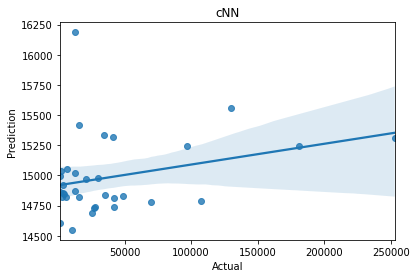

In [27]:
#plt.scatter(y_test, y_pred)
#plt.axhline(y=0, color='r', linestyle='-')
sns.regplot(y_test, y_pred)
plt.title('cNN')
#plt.xticks(rotation=90)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

In [37]:
ev = pd.DataFrame([y_test.ravel(), y_pred.ravel()]).T
ev.columns = ['test', 'pred']
ev[ev['pred']<15000].corr()

,test,pred
test,1.000000,-0.103976
pred,-0.103976,1.000000


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='test', ylabel='pred'>

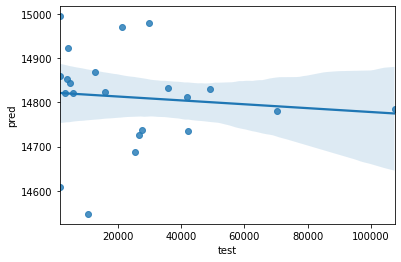

In [38]:
sns.regplot(ev[ev['pred']<15000].test, ev[ev['pred']<15000].pred)

In [30]:
y_pred[y_pred>15250]

array([15310.078, 15555.222, 15418.364, 15316.348, 16186.047, 15337.066],
      dtype=float32)

In [26]:
pd.DataFrame([y_test.ravel(), y_pred.ravel()]).T.corr()

,0,1
0,1.0000,0.2985
1,0.2985,1.0000


#### RNN

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.values.reshape((y_train.shape[0], 1))
y_test = y_test.values.reshape((y_test.shape[0], 1))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(132, 64, 1) (33, 64, 1) (132, 1) (33, 1)


In [40]:
model = Sequential()
model.add(LSTM(64, input_shape=(n_timesteps, n_features)))
model.add(Dense(64, activation="relu"))
model.add(Dense(n_outputs))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.fit(X_train, y_train, epochs=100, batch_size=5, verbose=1)
y_pred = model.predict(X_test)

Epoch 1/100
27/27 [==============================] - 3s 38ms/step - loss: 2589587968.0000
Epoch 2/100
27/27 [==============================] - 1s 28ms/step - loss: 2589406464.0000
Epoch 3/100
27/27 [==============================] - 1s 47ms/step - loss: 2589020160.0000
Epoch 4/100
27/27 [==============================] - 2s 74ms/step - loss: 2588203520.0000
Epoch 5/100
27/27 [==============================] - 1s 45ms/step - loss: 2587046144.0000
Epoch 6/100
27/27 [==============================] - 1s 31ms/step - loss: 2585553664.0000
Epoch 7/100
27/27 [==============================] - 1s 24ms/step - loss: 2583951872.0000
Epoch 8/100
27/27 [==============================] - 1s 24ms/step - loss: 2582138112.0000
Epoch 9/100
27/27 [==============================] - 1s 25ms/step - loss: 2580170752.0000
Epoch 10/100
27/27 [==============================] - 1s 25ms/step - loss: 2577946880.0000
Epoch 11/100
27/27 [==============================] - 1s 24ms/step - loss: 2575518208.0000
Epoch 12

27/27 [==============================] - 1s 25ms/step - loss: 2098950016.0000
Epoch 92/100
27/27 [==============================] - 1s 25ms/step - loss: 2093514752.0000
Epoch 93/100
27/27 [==============================] - 1s 25ms/step - loss: 2087854592.0000
Epoch 94/100
27/27 [==============================] - 1s 25ms/step - loss: 2082738560.0000
Epoch 95/100
27/27 [==============================] - 1s 24ms/step - loss: 2077641472.0000
Epoch 96/100
27/27 [==============================] - 1s 25ms/step - loss: 2072134656.0000
Epoch 97/100
27/27 [==============================] - 1s 24ms/step - loss: 2067380096.0000
Epoch 98/100
27/27 [==============================] - 1s 24ms/step - loss: 2062354304.0000
Epoch 99/100
27/27 [==============================] - 1s 25ms/step - loss: 2057674624.0000
Epoch 100/100
27/27 [==============================] - 1s 24ms/step - loss: 2052641664.0000


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


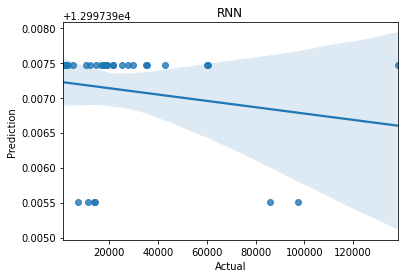

In [43]:
sns.regplot(y_test, y_pred)
plt.title('RNN')
#plt.xticks(rotation=90)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()